We start with MAF , defining the stellar density regions. Based on the MAF map, we 
obtained from NOAO archive the image corresponding to a given stellar density regime (with similar depth and filter as LSST r  ) : 

20% :  c4d_170122_055542_ooi_g_v1.fits.fz

15% : 

10% : 

5% :  c4d_160316_065235_ooi_g_v1.fits.fz

### Downloading NOAO images to NCSA 

Example for 20% field - the same for other field densities.

1) We went to http://archive.noao.edu/search/query  , selected : 
* ra,dec = 120.844   , -24.031667
* search box  =  10 arcmin 
* 90 < exposure < 125 
* telescope: CTIO 4m + DECam imager 
* Calibrated images only 
* public release date < today 

<img src="figures/1_query_noao.png">

2) We obtained  wtmap, dqmask, and  image, selected for staging
<img src="figures/2_query_results.png">

3) We ssh to NCSA : 

     ssh scichris@lsst-dev.ncsa.illinois.edu 
     
4) We download staged data from NOAO public server (user number is assigned at each search) : 

    lftp -u anonymous,lftp archive.noao.edu
    cd user_506119 
    mirror -L .   
5) We move the images to noao_data/  directory  with subdirectories  instcal/  wtmap/  dqmask/:
    
    mv c4d_170122_055542_ooi_g_v1.fits.fz noao_files/instcal/
    mv c4d_170122_055542_oow_g_v1.fits.fz noao_files/wtmap/
    mv c4d_170122_055542_ood_g_v1.fits.fz noao_files/dqmask/
    

### Processing the DECam images in NCSA with LSST Stack 

The following is an example for 20% field : those would be similar for other fields, with differing visit number .

1) We login to NCSA:  
    
    ssh scichris@lsst-dev.ncsa.illinois.edu
    
2) We setup the tools : 
        
    source /ssd/lsstsw/stack/loadLSST.bash
    setup obs_decam

3) We ingest the image ( assumed to reside in the noao_files/ subdirectories ) to repo/ directory : 
    
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_170122_055542*.fits.fz
   
At this stage we note what visit number is assigned to this image (it is also saved in the FITS header) , eg 
   
   ingest INFO: /home/scichris/noao_files/instcal/c4d_170122_055542_ooi_g_v1.fits.fz --<link>--> /home/scichris/repo/**0611980**/instcal0611980.fits.fz
   
   
4) Process the image  ( here we process all CCD's - otherwise we would specify ccdnum = #,  eg. 10 )  

    processCcd.py repo --rerun proc20perc  --id visit=611980  -C config_processccd.py --clobber-config


Move the results of LSST processing from the NCSA machine to a local workstation (eg. my laptop) : 

    cd /Users/chris/GradResearch/LSST_crowded_fields/data_products/LSST_Stack/DECam/
    mkdir 611980
    mv 611980
    scp scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/repo/rerun/proc20perc/611980/src/\*.fits .
     scp scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/repo/rerun/proc20perc/611980/calexp/\*.fits .

In [3]:
# Necessary imports ..

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import urllib.request


### Download decaps single-epoch catalog  : 

In [212]:
# the cat name is based on the image name ... 
image_name = 'c4d_170122_055542_ooi_g'
cat_name = image_name + '_v1.cat.fits'
file_name  = '../data_products/DEcAPS_Catalogs/single_epoch/' + cat_name

In [22]:
# download the single-epoch catalog...

url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
urllib.request.urlretrieve(url, file_name)

('../data_products/DEcAPS_Catalogs/single_epoch/c4d_170122_055542_ooi_g_v1.cat.fits',
 <http.client.HTTPMessage at 0x10ee94828>)

### From decaps single-epoch catalog obtain tile numbers to download band-merged catalogs 

In [213]:
decaps_hdu = fits.open(file_name)
#http://www.astropy.org/astropy-tutorials/FITS-tables.html
# hdu.info() would display all available tables - 
# there is a single catalog per CCD, 
# called 'S21_CAT', etc, based on CCD name. 

# save the zero point for this catalog 
decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  # one per entire image composed of multiple CCDs

In [223]:
decaps_hdu[163].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                    0                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
EXTNAME = 'N25_HDR '           / Extension name                                 
IRAF-TLM= '2017-01-25T00:51:40' / Time of last modification                     
INHERIT =                    T / Inherits global header                         
DATE    = '2017-01-25T00:51:04' / Date FITS file was generated                  
WCSAXES =                    2 / WCS Dimensionality                             
DETSEC  = '[22533:24572,6149

Obtain the coordinates of the corners and the center of the mosaic : 

In [24]:
centra = decaps_hdu[0].header['CENTRA']
centdec  = decaps_hdu[0].header['CENTDEC']
corner_dic = {'ra':np.zeros(4), 
              'dec':np.zeros(4)}

for corner in np.arange(1,5) : 
    corn_ra = 'CORN'+str(corner)+'RA'
    corn_dec  = 'CORN'+str(corner)+'DEC'
    corner_dic['ra'][corner-1] = decaps_hdu[0].header[corn_ra]
    corner_dic['dec'][corner-1] = decaps_hdu[0].header[corn_dec]


In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# initialize corners and center of the field in degrees 
corners  = SkyCoord(ra = corner_dic['ra'] * u.degree, 
                   dec = corner_dic['dec']*u.degree)
center = SkyCoord(ra = centra * u.degree, dec = centdec * u.degree)

# print
print('This DECaPS field is centered on ')
print('l,b = %f, %f'%(center.galactic.l.degree, center.galactic.b.degree))

This DECaPS field is centered on 
l,b = 242.428426, 3.773817


In [26]:
# note: handle both positive and negative cases of galactic latitude, 
# since longitude is always positive

# Make an array of tile latitudes: 

# closest  half integer to the maximum latitude:
top_latitude = np.ceil(max(corners.galactic.b.degree)) 
bottom_latitude = np.floor(min(corners.galactic.b.degree))
latitudes = np.arange(bottom_latitude, top_latitude) + 0.5


# Make an array of tile longitudes 

maxL = max(corners.galactic.l.degree) 
minL = min(corners.galactic.l.degree)
if maxL - minL > 200 : 
    # the boundary case ( around 0 longitude)
    left_longitude = np.floor(maxL)
    right_longitude = np.ceil(minL)
    a = np.arange(left_longitude, 360 ) +0.5
    longitudes = np.append(a, np.arange(1,right_longitude)-0.5) 
else : 
    # the standard case (both on same side )
    left_longitude = np.floor(minL)
    right_longitude = np.ceil(maxL)
    longitudes = np.arange(left_longitude, right_longitude) + 0.5
    

from itertools import product
# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/decam_flux_l1.5bm6.5.fits 
decaps_catalogs = []
for lat,lon in product(latitudes, longitudes):
    if lat >= 0 : 
        catname = 'decam_flux_l' + str(lon) + 'b'  + str(lat) + '.fits'
    if lat < 0 : 
        catname  = 'decam_flux_l' + str(lon) + 'b'  + 'm' + str(lat)[1:]+ '.fits'
    decaps_catalogs.append(catname)
    
    
print('We will try to download')
print(decaps_catalogs)
    
    

We will download
['decam_flux_l241.5b2.5.fits', 'decam_flux_l242.5b2.5.fits', 'decam_flux_l243.5b2.5.fits', 'decam_flux_l241.5b3.5.fits', 'decam_flux_l242.5b3.5.fits', 'decam_flux_l243.5b3.5.fits', 'decam_flux_l241.5b4.5.fits', 'decam_flux_l242.5b4.5.fits', 'decam_flux_l243.5b4.5.fits', 'decam_flux_l241.5b5.5.fits', 'decam_flux_l242.5b5.5.fits', 'decam_flux_l243.5b5.5.fits']


In [46]:
print('First check which tiles are available : ')
# Check that against the list of what is available ... 
# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/
url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'
with urllib.request.urlopen(url) as response:
    html = response.read()


In [63]:
# we convert bytes object to a string 
html_string = html.decode("utf-8") 

good_catalogs = []
for i in range(0,len(decaps_catalogs)) :
    if decaps_catalogs[i] in html_string:
        good_catalogs.append(decaps_catalogs[i])

In [64]:
print('We found that these are available : ')
print(good_catalogs)


['decam_flux_l241.5b2.5.fits',
 'decam_flux_l242.5b2.5.fits',
 'decam_flux_l243.5b2.5.fits',
 'decam_flux_l241.5b3.5.fits',
 'decam_flux_l242.5b3.5.fits',
 'decam_flux_l243.5b3.5.fits',
 'decam_flux_l241.5b4.5.fits',
 'decam_flux_l242.5b4.5.fits',
 'decam_flux_l243.5b4.5.fits',
 'decam_flux_l242.5b5.5.fits',
 'decam_flux_l243.5b5.5.fits']

In [72]:
print('But these have not been downloaded yet:')
downloaded = os.listdir('../data_products/DEcAPS_Catalogs/band_merged/')
mask_to_download = ~np.in1d(good_catalogs, downloaded)
get_catalogs = np.array(good_catalogs)[mask_to_download]
print(get_catalogs)

But these have not been downloaded yet:
['decam_flux_l242.5b5.5.fits' 'decam_flux_l243.5b5.5.fits']


In [73]:
# Note - this may take a while to run because it 
# will download all the needed catalog tiles ... 
import urllib.request
for file in get_catalogs : 
    file_name = '../data_products/DEcAPS_Catalogs/band_merged/'+file
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'+file
    urllib.request.urlretrieve(url, file_name)

Aside : illustrate the downloaded tiles : 

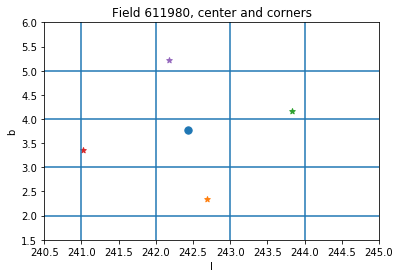

In [18]:
%matplotlib inline
        
# NOTE : The illustration only really works  for positive latitude, ( eg. b = 3,6 )
# and both longitudes must be on the same side of the 0 meridian ( eg. l = 241, 245)

# The decaps fields are arranged as a grid of 
# fields : 
l_field, b_field = center.galactic.l.degree, center.galactic.b.degree

lmin = np.floor(l_field) - 1 
bmin = np.floor(b_field) - 1
fig,ax = plt.subplots(1,1)
for l in np.arange(lmin,lmin+4) :
    ax.axvline(l)
for b in np.arange(bmin,bmin+4):
    ax.axhline(b)
ax.set_xlim(lmin-0.5,lmin+4)
ax.set_ylim(bmin-0.5, bmin+4)
ax.scatter(l_field, b_field, s=54)
for c in corners : 
    ax.scatter(c.galactic.l, c.galactic.b, s=34, marker='*')
ax.set_xlabel('l')
ax.set_ylabel('b')
ax.set_title('Field 611980, center and corners')

### Completeness : match the decals single-epoch catalog to LSST source catalog 

We match the decals catalog that corresponds exactly to the LSST-processed image, CCD by CCD. 
1) Read the LSST source catalogs for a given CCD 

In [75]:
visit = '611980'
outDir = '../data_products/LSST_Stack/DECam/'+visit+'/'

# read ccd by ccd,  and check corresponding ccd data in the 
# decals single-epoch catalog


from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from scipy.stats import binned_statistic as bs

'/Users/chris/GradResearch/LSST_crowded_fields/code'

In [324]:
visit = '611980'
outDir = '../data_products/LSST_Stack/DECam/'+visit+'/'


# first check calexp for zero point magnitude
# it is exactly the same for all CCDs in a mosaic 
calexp_files = os.listdir(outDir+'calexp/')
fname = calexp_files[0]
# read in the zeropoint from the calexp file 
calexp_hdu = fits.open(outDir+'calexp/' + fname)
lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
print('The lsst measured zeropoint for decam is %f'%lsst_zeropoint)

# Make only once : the translation of ccdnum to ccdname,  to position in the 
# decals hdu 

ccd_name_dict = {}
catalog_decaps_pos = {}

for i in range(1,180) : 
    if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
        ccdnum = decaps_hdu[i].header['CCDNUM']
        detpos = decaps_hdu[i].header['DETPOS']
        ccd_name_dict[ccdnum] = detpos
        catalog_decaps_pos[ccdnum] = int(i+2)
        
# The coveted dictionary of ccdnum  vs ccdname ! 
print(np.ravel(ccd_name_dict))

# and the translation of ccdnum  to hduposition of the catalog .... 
print(np.ravel(catalog_decaps_pos))


The lsst measured zeropoint for decam is 29.047000
[ {1: 'S29', 3: 'S31', 4: 'S25', 5: 'S26', 6: 'S27', 7: 'S28', 8: 'S20', 9: 'S21', 10: 'S22', 11: 'S23', 12: 'S24', 13: 'S14', 14: 'S15', 15: 'S16', 16: 'S17', 17: 'S18', 18: 'S19', 19: 'S8', 20: 'S9', 21: 'S10', 22: 'S11', 23: 'S12', 24: 'S13', 25: 'S1', 26: 'S2', 27: 'S3', 28: 'S4', 29: 'S5', 30: 'S6', 31: 'S7', 32: 'N1', 33: 'N2', 34: 'N3', 35: 'N4', 36: 'N5', 37: 'N6', 38: 'N7', 39: 'N8', 40: 'N9', 41: 'N10', 42: 'N11', 43: 'N12', 44: 'N13', 45: 'N14', 46: 'N15', 47: 'N16', 48: 'N17', 49: 'N18', 50: 'N19', 51: 'N20', 52: 'N21', 53: 'N22', 54: 'N23', 55: 'N24', 56: 'N25', 57: 'N26', 58: 'N27', 59: 'N28', 60: 'N29', 62: 'N31'}]
[ {1: 3, 3: 6, 4: 9, 5: 12, 6: 15, 7: 18, 8: 21, 9: 24, 10: 27, 11: 30, 12: 33, 13: 36, 14: 39, 15: 42, 16: 45, 17: 48, 18: 51, 19: 54, 20: 57, 21: 60, 22: 63, 23: 66, 24: 69, 25: 72, 26: 75, 27: 78, 28: 81, 29: 84, 30: 87, 31: 90, 32: 93, 33: 96, 34: 99, 35: 102, 36: 105, 37: 108, 38: 111, 39: 114, 40: 117, 4

In [334]:
#def process_src_ccd():
src_files = os.listdir(outDir+'src/')
start = len('src-0'+visit+'_')
stop = len('.fits')
ccdnum  = src_files[0][start:-stop]  # string
ccd_number = float(ccdnum)
fname = 'src-0'+visit+'_'+ccdnum+'.fits'
hdu = fits.open(outDir +'src/'+ fname)
print(fname)

# convert to an AstroPy table 
ccd_data = Table(hdu[1].data)

# only consider positive fluxes... 
mask_neg_fluxes = ccd_data['base_PsfFlux_flux'].data > 0
# just select rows that don't have negative fluxes...
ccd_data_good = ccd_data[mask_neg_fluxes]
ccd_data_good['lsst_mag'] = -2.512 * np.log10(ccd_data_good['base_PsfFlux_flux'])   +\
   lsst_zeropoint

# Display mapping information
print('For ccd number %d ' % ccd_number)
print('The ccd name is %s'% ccd_name_dict[ccd_number])
print('and the position in the decaps hdu catalog is %d'%catalog_decaps_pos[ccd_number])

# read in decaps single-epoch catalog for that ccd... 
ccd_decaps_cat =  Table(decaps_hdu[catalog_decaps_pos[ccd_number]].data) 

# convert the fluxes to magnitudes 
ccd_decaps_cat['decaps_mag'] = -2.512 * np.log10(ccd_decaps_cat['flux'].data) +\
decaps_zeropoint


# Match sources from  decaps to lsst  per ccd 
# decam coordinates
decam_coord = SkyCoord(ra  = ccd_decaps_cat['ra']*u.degree, 
                       dec = ccd_decaps_cat['dec']*u.degree)  

# lsst coordinates : in radians ! 
lsst_coord = SkyCoord(ra = ccd_data_good['coord_ra']*u.radian, 
                      dec= ccd_data_good['coord_dec']*u.radian)  


# indices are into lsst ccd catalog 
# match decaps into lsst ... 
idx, d2d, d3d = decam_coord.match_to_catalog_sky(lsst_coord)  

# stack the two catalogs 
lsst_decam= hstack([ccd_decaps_cat ,ccd_data_good[idx]],
               table_names=['decam','lsst']  )

print('There are %d decaps sources  and %d lsst sources.'%(len(decam_coord),
                                                      len(lsst_coord))
     )

src-0611980_23.fits
For ccd number 23 
The ccd name is S12
and the position in the decaps hdu catalog is 66
There are 5068 decaps sources  and 4461 lsst sources.


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


 3775 decaps srcs have an lsst match within 2 arcsec
 3640 decaps srcs have an lsst match within 0.50 mag
 3573 decaps srcs have an lsst match fulfilling both criteria


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


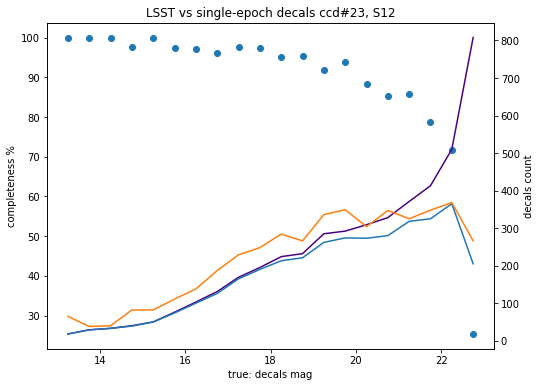

In [362]:
# matches within two arcsec...
cut_arcsec = 2 
mask_arcsec = d2d.arcsec < cut_arcsec

# matches within 0.5 mag from one another ... 
lsst_decam['dmag'] = lsst_decam['lsst_mag'] - lsst_decam['decaps_mag']
cut_mag = 0.5
mask_mag = abs(lsst_decam['dmag'].data) < cut_mag
mask_comb  = mask_arcsec * mask_mag


print(' %d decaps srcs have an lsst match within %d arcsec'%(
    np.sum(mask_arcsec), cut_arcsec)
     )
print(' %d decaps srcs have an lsst match within %.2f mag'%(
    np.sum(mask_mag), cut_mag)
     )
print(' %d decaps srcs have an lsst match fulfilling both criteria'%np.sum(mask_comb)
     )

# make  a smaller table with only 'good matches', 
# keeping only the magnitudes.. 
# matched =  lsst_decam[mask_comb][['lsst_mag', 'decaps_mag']]
      
      
# Using the original table, make a column to flag which 
# decaps srcs have a good lsst match 

# Initialize with zeros
lsst_decam['lsst_match'] = 0

# Set to 1 only where the match is good, i.e. fulfills the combined selection masks
lsst_decam['lsst_match'][mask_comb] = 1 
      
# Plot completeness ... 
bins = np.arange(12,23,0.5)

stat_mag = bs(lsst_decam['decaps_mag'], lsst_decam['decaps_mag'] , bins =bins ,
          statistic='count')

stat_count = bs(lsst_decam['decaps_mag'], lsst_decam['lsst_match'] , bins =bins ,
          statistic=np.sum)

decaps_count = stat_mag.statistic[1:]
lsst_matched_count = stat_count.statistic[1:]

completeness = 100 * (lsst_matched_count / decaps_count)

%matplotlib inline
fig,ax = plt.subplots(1,1,figsize = (8,6))
ax.scatter(stat_mag.bin_edges[2:]+0.25, completeness)
ax.set_ylabel('completeness %')
ax.set_xlabel('true: decals mag')
ax.set_title('LSST vs single-epoch decals ccd#'+str(int(ccd_number))+\
             ', '+ ccd_name_dict[ccd_number])


ax2 = ax.twinx()

ax2.plot(stat_mag.bin_edges[2:]+0.25, decaps_count, c='indigo')
ax2.set_ylabel('decals count')

# single out only those decals that have a good lsst match,
# so that we can plot the counts of lsst along the magnitude 
# of matched decals source... 
matched =  lsst_decam[mask_comb][['lsst_mag', 'decaps_mag']]
stat_lsst = bs(  matched['decaps_mag'], matched['lsst_mag'] , bins = bins , 
             statistic = 'count' ) 

ax2.plot(stat_lsst.bin_edges[2:]+0.25, stat_lsst.statistic[1:])


# plot also raw lsst along lsst magnitudes ...
stat_raw = bs(ccd_data_good['lsst_mag'], ccd_data_good['lsst_mag'],
             bins=bins, statistic='count')
ax2.plot(stat_raw.bin_edges[2:]+0.25, stat_raw.statistic[1:])

In [337]:
len(lsst_decam)

5068

18.4788176331
20.737100766
19.807636617
16.8199698157
21.3916851169
18.8644894007
21.1783409655
21.5300589587
16.3772197778
21.0198339369
15.1108898537


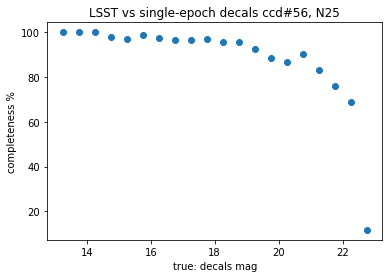

In [ ]:
# Plot completeness : 
# how many decaps sources does lsst recover ?

# we classify a  match as good if :
# 1)  lsst counterpart is within 2 arcsec
# 2) lsst match has magnitude within 0.5 mag from the decaps magnitude 

